In [1]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 920
n_splits = 5

/home2/y2023/m2311203/.conda/envs/CMI2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('../input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('../input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('../input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("../input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("../input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 12.26it/s]


In [3]:
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

Train Shape : (2736, 155) || Test Shape : (20, 154)


In [4]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    #しきい値を出力
    print(f"Optimized Thresholds : {KappaOPtimizer.x}")
    tKappa = quadratic_weighted_kappa(y, oof_tuned)
    CVs.append(tKappa)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,model

In [6]:
Params7 = {'learning_rate': 0.03884249148676395, 'max_depth': 12, 'num_leaves': 413, 'min_data_in_leaf': 14,
           'feature_fraction': 0.7987976913702801, 'bagging_fraction': 0.7602261703576205, 'bagging_freq': 2, 
           'lambda_l1': 4.735462555910575, 'lambda_l2': 4.735028557007343e-06} # CV : 0.4094 | LB : 0.471
SEED = 13123
Light = lgb.LGBMRegressor(**Params7,random_state=SEED, verbose=-1,n_estimators=500)
#Submission,model = TrainML(Light,test)

Training Folds: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]

Mean Train QWK --> 0.6490
Mean Validation QWK ---> 0.3852


Optimized Thresholds : [0.53751737 0.9912083  2.73581288]
----> || Optimized QWK SCORE ::  0.462


<Axes: ylabel='Count'>

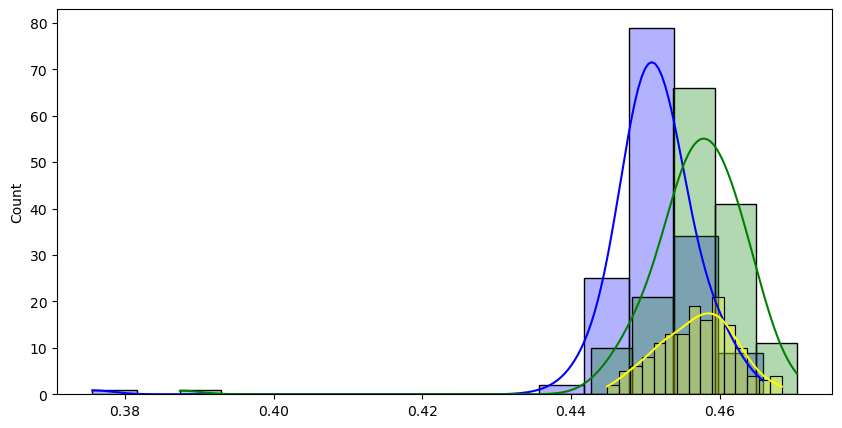

In [8]:
CVs = []
n = 150
for i in range(n):
    n_splits = 5
    Light = lgb.LGBMRegressor(**Params7,random_state=i+5, verbose=-1,n_estimators=75)
    Submission,model = TrainML(Light,test)
CV_n5 = CVs
CVs = []
for i in range(n):
    n_splits = 25
    Light = lgb.LGBMRegressor(**Params7,random_state=i+5, verbose=-1,n_estimators=75)
    Submission,model = TrainML(Light,test)
CV_n25 = CVs
CVs = []
for i in range(n):
    n_splits = 50
    Light = lgb.LGBMRegressor(**Params7,random_state=i+5, verbose=-1,n_estimators=75)
    Submission,model = TrainML(Light,test)
CV_n50 = CVs
plt.figure(figsize=(10, 5))
#3つを比較
sns.histplot(CV_n5, bins=15, kde=True,alpha=0.3,color='blue')
sns.histplot(CV_n50, bins=15, kde=True,alpha=0.3,color='green')
sns.histplot(CV_n25, bins=15, kde=True,alpha=0.3,color='yellow')

<Axes: ylabel='Count'>

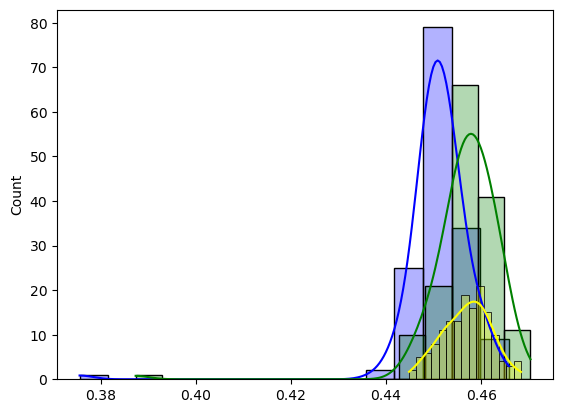

In [15]:
sns.histplot(CV_n5, bins=15, kde=True,alpha=0.3,color='blue')
sns.histplot(CV_n50, bins=15, kde=True,alpha=0.3,color='green')
sns.histplot(CV_n25, bins=15, kde=True,alpha=0.3,color='yellow')

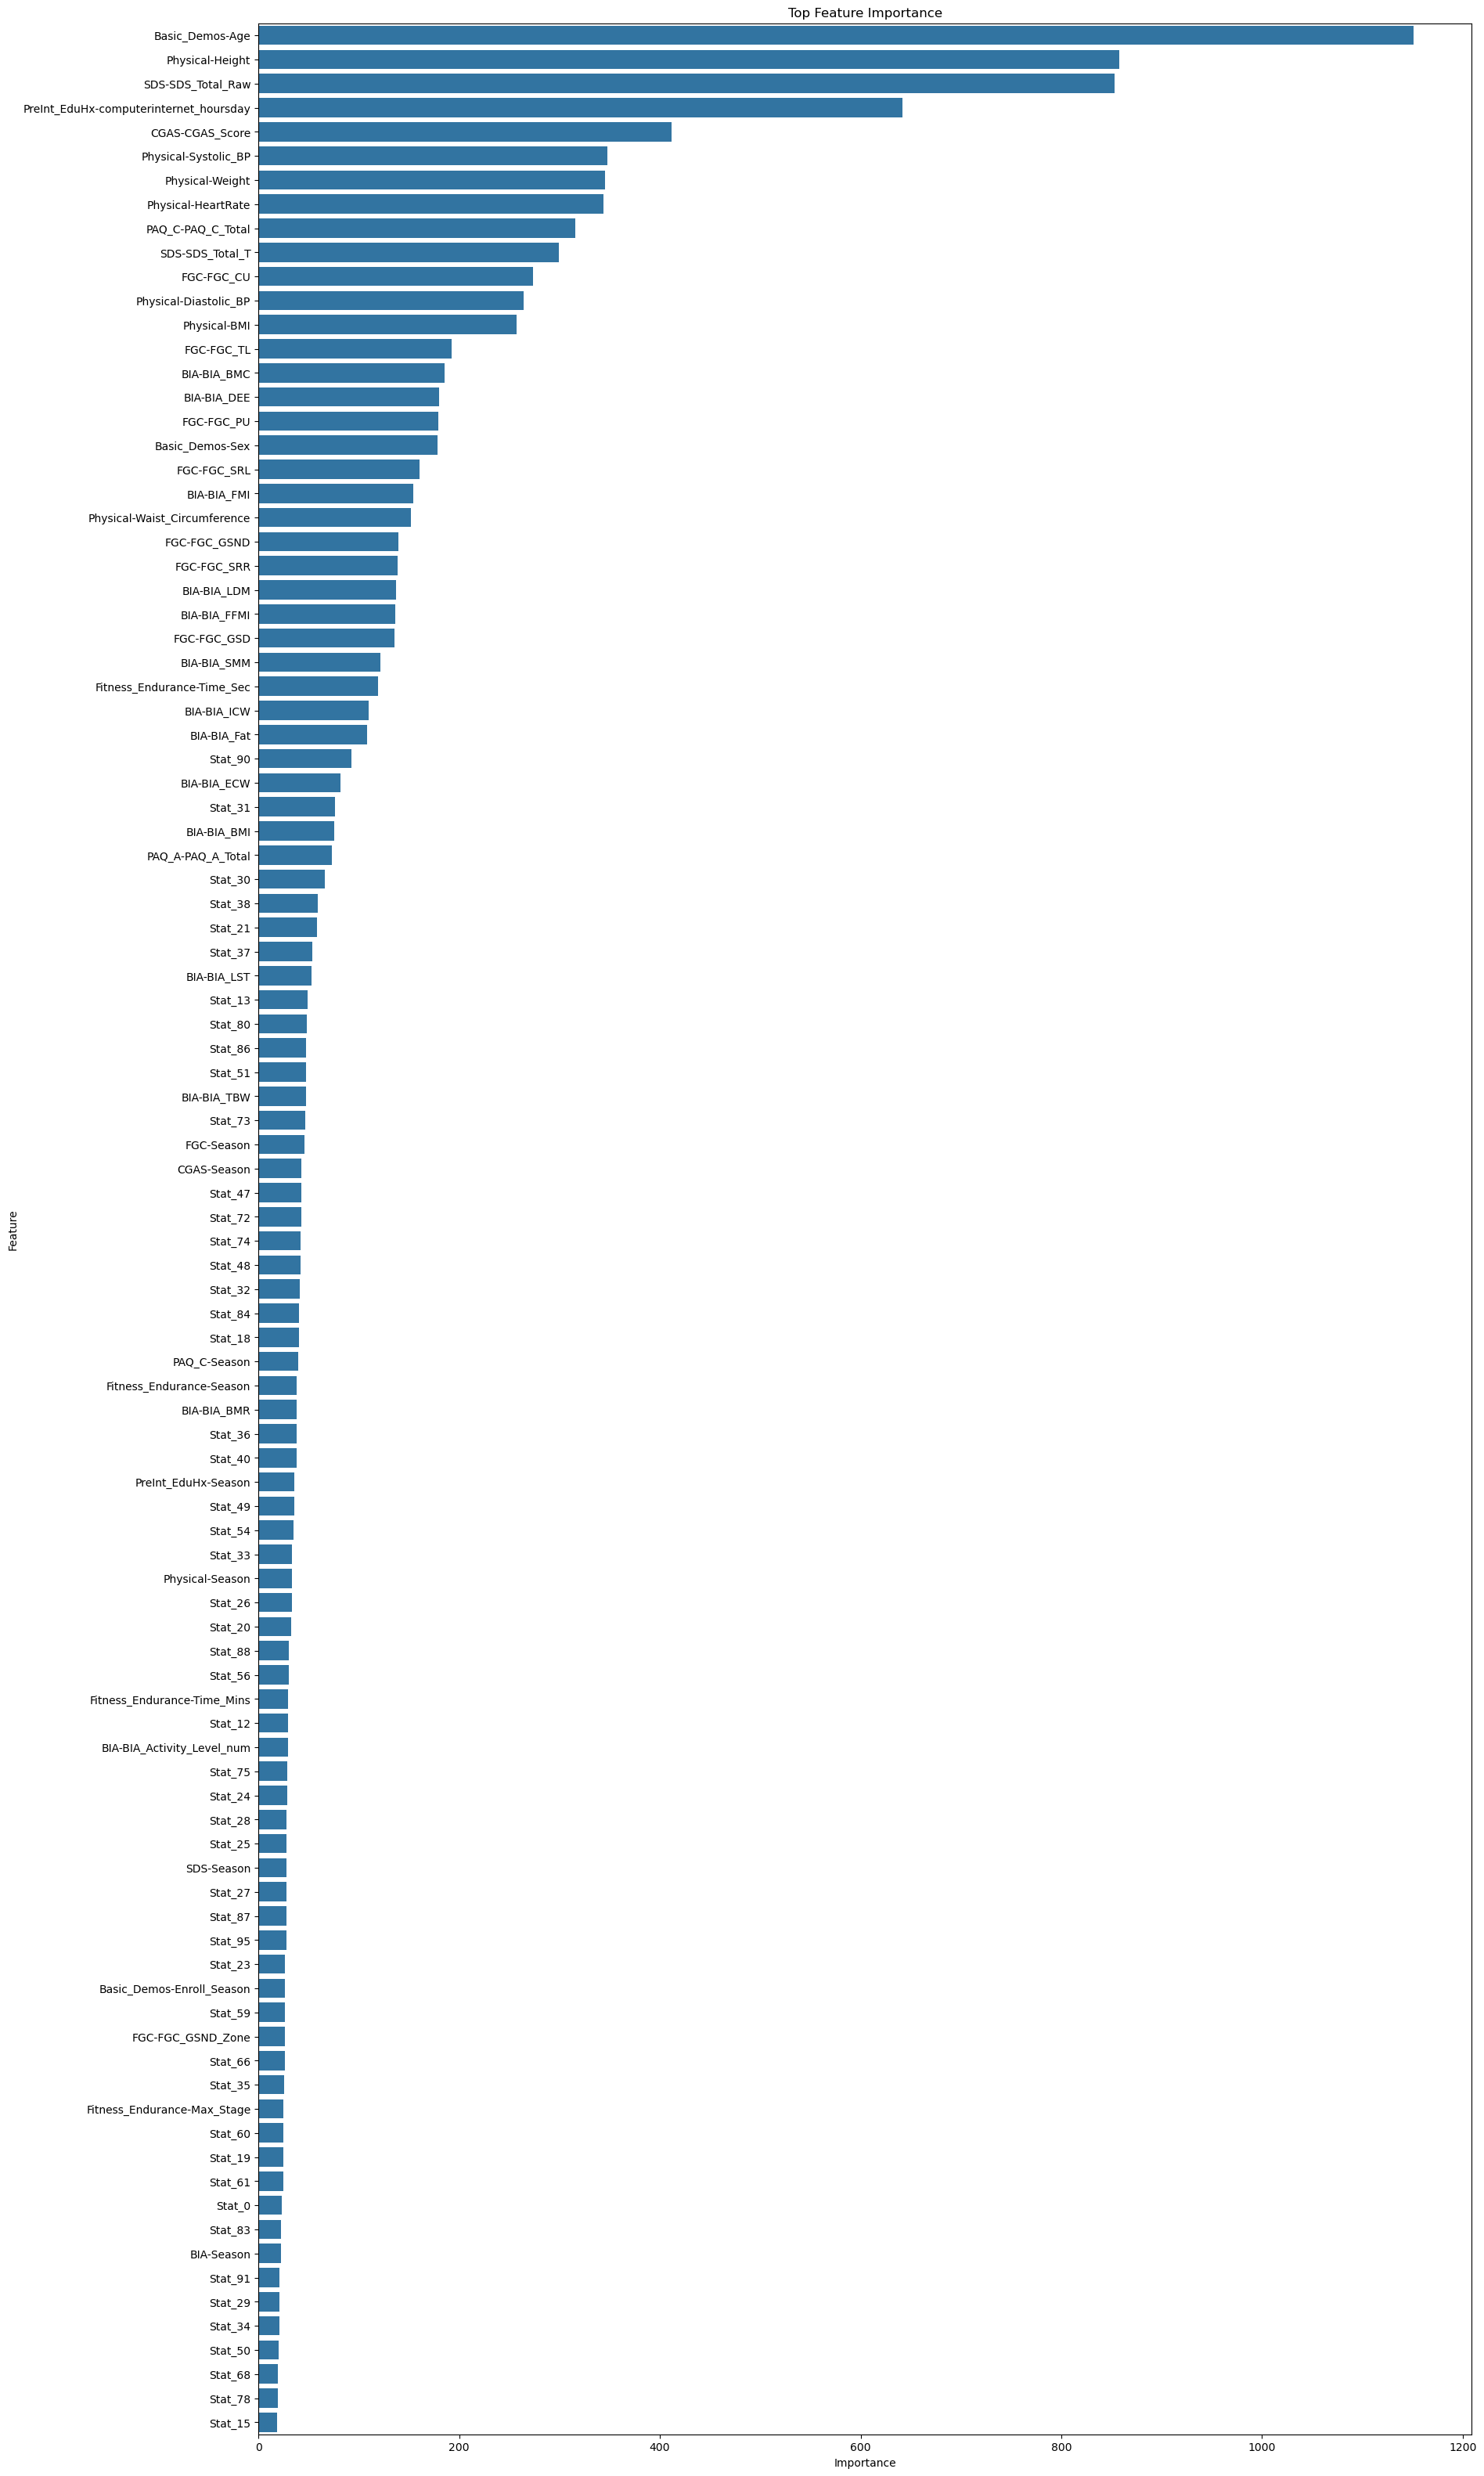

In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature': model.booster_.feature_name(),
    'Importance': model.booster_.feature_importance(importance_type='gain')
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 40))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100)) 
plt.title("Top Feature Importance")
plt.show()

In [ ]:
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
0    11
1     6
2     3
Name: count, dtype: int64


In [ ]:
!jupyter nbconvert --to python exp002.ipynb

[NbConvertApp] Converting notebook exp002.ipynb to python
[NbConvertApp] Writing 8492 bytes to exp002.py
